# beta-v area integration

This notebook tests whether we observe a zero $\beta V$ when integrated within a closed streamfunction contour.

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc
import gcm_filters
import os

import cartopy.feature as cfeature

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41015,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:40839,Total threads: 4
Dashboard: /proxy/40969/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:36749,


In [3]:
start_time, end_time = '2041-01-01', '2041-01-31'
time_period = '1 month'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [5]:
var_name = 'beta_v'
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

In [6]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')

area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1).isel(xq = slice(1, None)).isel(yq = slice(1, None))
#area_bu = area_bu * (vmo_2d_itp[0]/vmo_2d_itp[0])
area_bu_NA = area_bu.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

temp = cc.querying.getvar(expt[2], 'tos', session, frequency = '1 monthly', n = 1, chunks = {})
area = cc.querying.getvar(expt[2], 'areacello', session, frequency = 'static', n = 1)
#area = area * (temp[0]/temp[0])
area_NA = area.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

In [7]:
geolon = cc.querying.getvar(expt[2], 'geolon', session, frequency = 'static', n = 1)
geolat = cc.querying.getvar(expt[2], 'geolat', session, frequency = 'static', n = 1)

In [8]:
# Define the levels for the contourf
lvls = np.linspace(-80, 80, 41)

def psi_func(axes):

    ## Cell-centred x-directed mass transport vertically summed
    tx_trans_int_z = umo_2d.mean('time')
    
    ## 2-dimensional lat-lon grid
    geolon_t = geolon
    geolat_t = geolat
    
    ## Calculation of streamfunction from x-directed mass transport
    psi = -tx_trans_int_z.cumsum('yh')/(1e6*ρ0) # divide by 1e6 to convert m^3/s -> Sv
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
    psi_g = psi - psi_acc
    psi_g = psi_g.rename('psi')
    psi_g.attrs['long_name'] = 'Barotropic Streamfunction'
    psi_g.attrs['units'] = 'Sv'
    psi_g = psi_g.where(~np.isnan(tx_trans_int_z))
    
    ## Interpolating streamfunction to cell centre grid
    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((psi_g, geolat_t))
    data.coords['xq'].attrs.update(axis='X')
    data.coords['xh'].attrs.update(axis='X',c_grid_axis_shift=0.5)
    g = xgcm.Grid(data, periodic=['X'])
    psi_g = g.interp(psi_g, 'X')
    psi_g = psi_g.rename('psi')
    
    ## Plotting begins
    
    ## Plotting land and continent boundaries
    axes.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
    axes.gridlines(color = 'grey', linestyle = '--')
    
    ## Plotting global streamfunction
    cf = axes.contourf(psi_g.xh.values, psi_g.yh.values, (psi_g * np.sign(psi.yh)).values, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())
    
    ## Specifying colorbar attributes
    cbar = fig.colorbar(cf, ax = axes, orientation = 'vertical', shrink = 0.4, ticks = [-80, -40, 0, 40, 80], pad = 0.04)#, aspect = 25, fraction = 0.05)
    cbar.set_label('Transport (Sv)', fontsize = 8)
    cbar.ax.tick_params(labelsize = 8)
    
    return psi_g

## Subtropical gyre

We consider 4 areas for area-integration (plotted below):
1. $\Psi$ >= 10 Sv
2. $\Psi$ >= 8 Sv
3. $\Psi$ >= 5 Sv
4. $\Psi$ >= 0 Sv

In [19]:
if(time_period == '1 month'):
    psi_itp = (vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min + 5, y_max)).mean('time').cumsum('xq'))/(1e6 * ρ0)
    psi_itp_NA = psi_itp
    area_bu_NA = area_bu.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min + 5, y_max))
else:
    fig, ax1 = plt.subplots(figsize = (6*1.2, 3.6*1.2), subplot_kw = {'projection': ccrs.Robinson(central_longitude = 260)})
    psi = psi_func(ax1)
    ax1.set_title('')
    psi_itp = grid.interp(psi, 'X')
    psi_itp = grid.interp(psi_itp, 'Y')
    psi_itp_NA = psi_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

In [20]:
area_bu_NA = (area_bu_NA * vmo_2d_itp[0])/(vmo_2d_itp[0])

### Area maps without any alterations

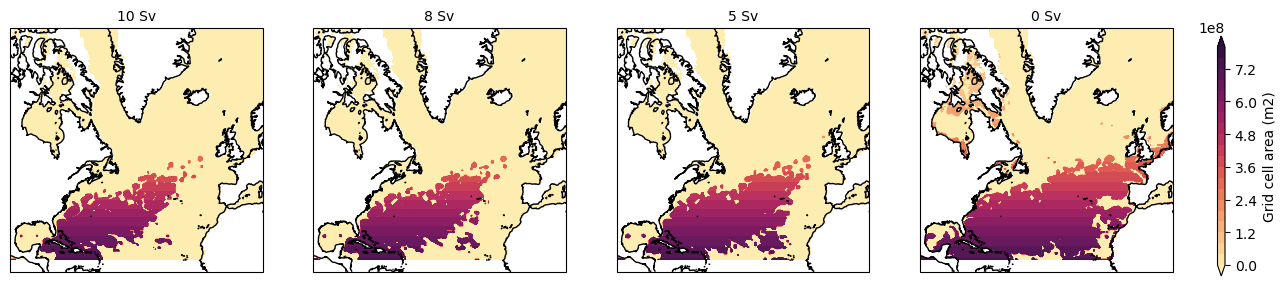

In [23]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 4), subplot_kw = {'projection': projection})

cutoff_contours = [10, 8, 5, 0]
for i, j in enumerate(cutoff_contours):
    mask = xr.where(psi_itp >=cutoff_contours[i], 1, 0)
    temp = area_bu_NA * mask
    p1 = axes[i].contourf(area_bu_NA.xq, area_bu_NA.yq, temp, levels = np.linspace(0, 8e8, 21), 
                     cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.93, 0.18, 0.005, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Grid cell area (m2)', fontsize = 10)

for i in range(4):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title(str(cutoff_contours[i]) + ' Sv', fontsize = 10)

### Area integrations for different streamfunction contours

### What sort of errors should we expect?

My hypothesis is that we are not properly resolving the Gulf Stream due to our model resolution. In fact, any streamfunction contour in which zonal or meridional variations are large won't be resolved properly. To quantify this, we do an error analysis for the Gulf Stream. We assume (i) ~4 Sv of unaccounted flow, and (ii) there are no other regions than the Gulf Stream in the subtropical gyre where variations are large enough to produce errors.

In [24]:
dΨ = 4e6 ## in Sv - Estimate of resolution-dependent erroneous flow due to not picking exactly the contour we want
dA = (40 - 20) * 100 * 1e3 * 25 * 1e3 ## in m2 - Estimate of area occupied by a longitude transect (~ 25 km) in Gulf Stream (~20-40 N)
Agrid = 25 * 1e3 ## in m2 - To convert streamfunction into depth integrated flow, equal to dx (25 km) 
β = 2e-11 ## Rossby parameter

dβV_int = β * (dΨ/Agrid) * dA
print('Error is ~' + str(dβV_int) + ' m3/s2')

Error is ~159.99999999999997 m3/s2


In [25]:
mask10 = xr.where(psi_itp >=10, 1, 0)
mask05 = xr.where(psi_itp >=5,  1, 0)
mask08 = xr.where(psi_itp >=8,  1, 0)
mask00 = xr.where(psi_itp >=0,  1, 0)

In [26]:
beta_v = xr.open_dataset(base_dir + dir_names[2] + '/141-180/' + 'beta_v' + '.nc')['beta_v'].sel(time = slice(start_time, end_time)).mean('time')
BPT = xr.open_dataset(base_dir + dir_names[2] + '/141-180/' + 'BPT' + '.nc')['BPT'].sel(time = slice(start_time, end_time)).mean('time')
beta_v = xr.where(np.isnan(BPT), np.nan, beta_v)

In [27]:
print('Integrated betaV for psi >= 10 Sv: ' + str((mask10 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 8 Sv: ' + str((mask08 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 5 Sv: ' + str((mask05 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 0 Sv: ' + str((mask00 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))

Integrated betaV for psi >= 10 Sv: 638.855339479752
Integrated betaV for psi >= 8 Sv: 606.7095375223737
Integrated betaV for psi >= 5 Sv: 550.2787047017073
Integrated betaV for psi >= 0 Sv: 408.4820731004425


We get errors larger than our predictions. This could be because of our two assumptions. These assumptions can be discussed in more detail by looking at transects.

### How about transects?

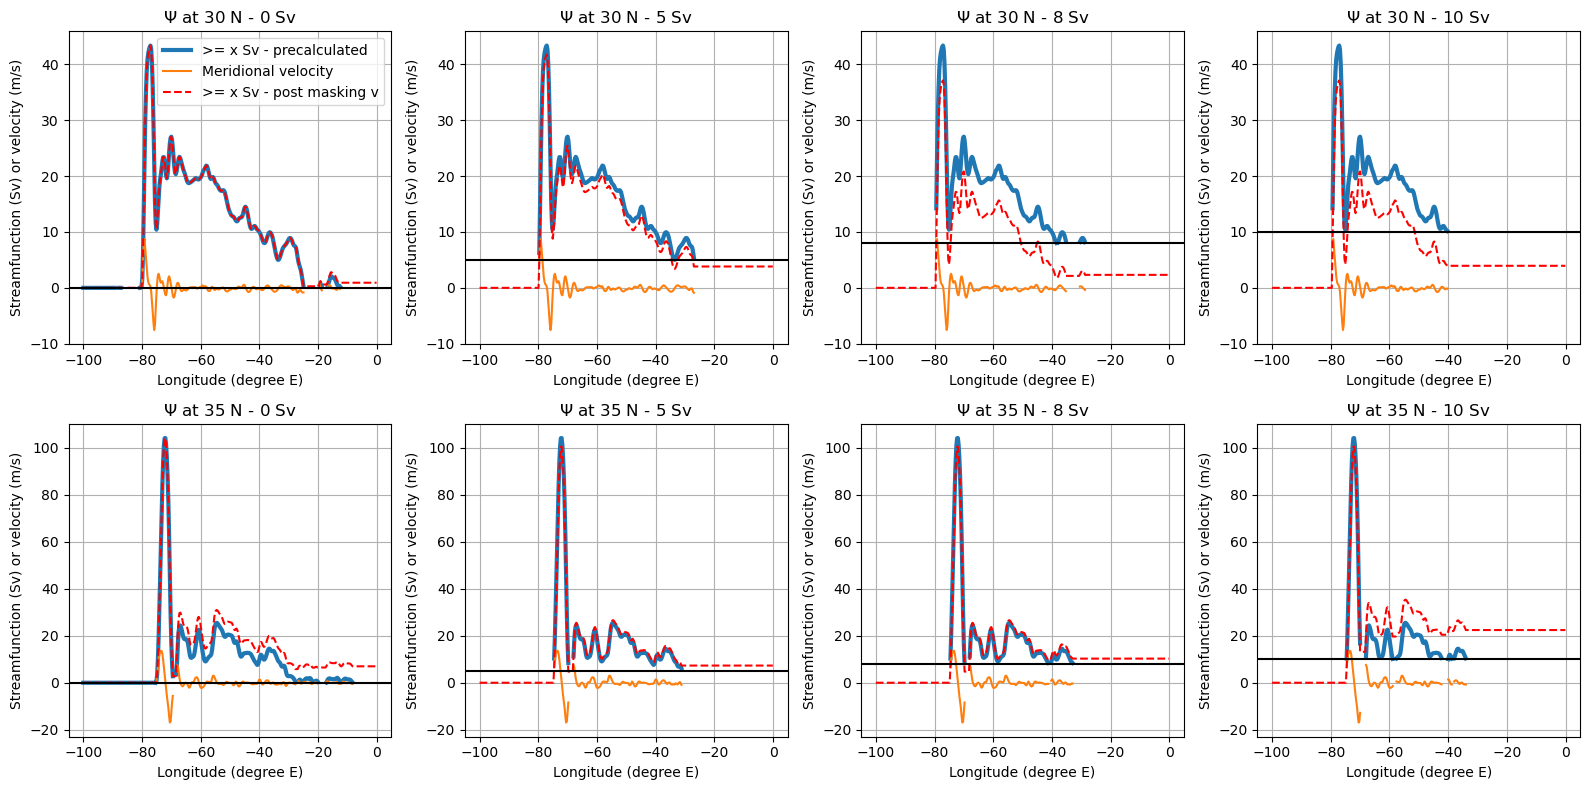

In [29]:
def psi_transect_plot_cumsum(row, col, cutoff, latitude):
    psi_itp.where(psi_itp >=cutoff).sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).plot(label = '>= x Sv - precalculated', 
                                                                                                          lw = 3, ax = axes[row][col])
    (vmo_2d_itp/1e6/ρ0).where(psi_itp >=cutoff).sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).plot(label = 'Meridional velocity', 
                                                                                                                      ax = axes[row][col])
    (vmo_2d_itp/1e6/ρ0).where(psi_itp >=cutoff).sel(yq = latitude, method = 'nearest').sel(xq = slice(-100, 0)).cumsum(
        'xq').plot(label = '>= x Sv - post masking v', ls = '--', ax = axes[row][col], color = 'red')
    axes[row][col].axhline(cutoff, color = 'black')
    axes[row][col].grid()
    axes[row][col].set_ylabel('Streamfunction (Sv) or velocity (m/s)')
    axes[row][col].set_xlabel('Longitude (degree E)')
    axes[row][col].set_title('$\Psi$ at ' + str(latitude) + ' N - ' + str(cutoff) + ' Sv')
    if(row == 0 and col == 0):
        axes[row][col].legend()

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8))

psi_transect_plot_cumsum(0, 0, 0, 30)
psi_transect_plot_cumsum(0, 1, 5, 30)
psi_transect_plot_cumsum(0, 2, 8, 30)
psi_transect_plot_cumsum(0, 3, 10, 30)
psi_transect_plot_cumsum(1, 0, 0, 35)
psi_transect_plot_cumsum(1, 1, 5, 35)
psi_transect_plot_cumsum(1, 2, 8, 35)
psi_transect_plot_cumsum(1, 3, 10, 35)

plt.tight_layout()

In the plot above:
1. Blue line is the precalculated $\Psi$, masking is performed after calculation.
2. Orange line is the pre-loaded meridional velocity, masking is performed after loading.
3. Red dashed line is calculated by cumulatively integrating the meridional velocity. This should be equal to the black horizontal line (?)
4. Black line is the streamfunction contour for our mask.

### Plotting area-integration for each latitude

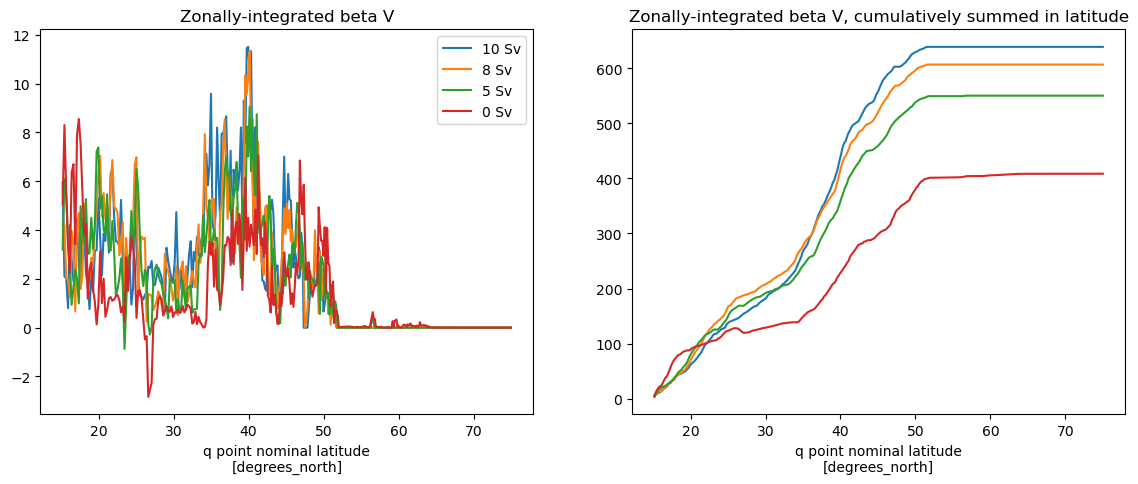

In [42]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))

(mask10 * area_bu_NA * beta_v).sum(['xq']).plot(ax = axes[0], label = '10 Sv')
(mask08 * area_bu_NA * beta_v).sum(['xq']).plot(ax = axes[0], label = '8 Sv')
(mask05 * area_bu_NA * beta_v).sum(['xq']).plot(ax = axes[0], label = '5 Sv')
(mask00 * area_bu_NA * beta_v).sum(['xq']).plot(ax = axes[0], label = '0 Sv')

(mask10 * area_bu_NA * beta_v).sum(['xq']).cumsum('yq').plot(ax = axes[1], label = '10 Sv')
(mask08 * area_bu_NA * beta_v).sum(['xq']).cumsum('yq').plot(ax = axes[1], label = '8 Sv')
(mask05 * area_bu_NA * beta_v).sum(['xq']).cumsum('yq').plot(ax = axes[1], label = '5 Sv')
(mask00 * area_bu_NA * beta_v).sum(['xq']).cumsum('yq').plot(ax = axes[1], label = '0 Sv')

axes[0].set_title('Zonally-integrated beta V')
axes[1].set_title('Zonally-integrated beta V, cumulatively summed in latitude')
axes[0].legend()

### Area maps with 50 N cutoff latitude

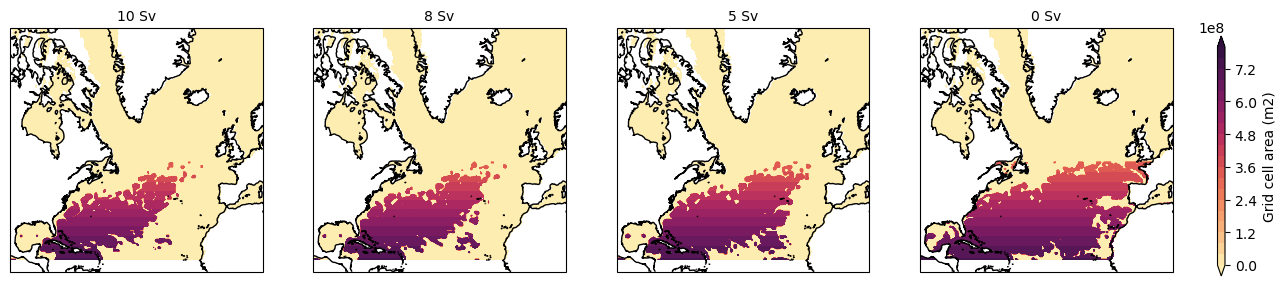

In [43]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 4), subplot_kw = {'projection': projection})

cutoff_contours = [10, 8, 5, 0]
for i, j in enumerate(cutoff_contours):
    mask = xr.where(psi_itp >=cutoff_contours[i], 1, 0)
    mask = xr.where(mask.yq <=50, mask, 0)
    temp = area_bu_NA * mask
    p1 = axes[i].contourf(area_bu_NA.xq, area_bu_NA.yq, temp, levels = np.linspace(0, 8e8, 21), 
                     cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.93, 0.18, 0.005, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Grid cell area (m2)', fontsize = 10)

for i in range(4):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title(str(cutoff_contours[i]) + ' Sv', fontsize = 10)

In [44]:
mask10 = xr.where(psi_itp >=10, 1, 0)
mask10 = xr.where(mask10.yq <=50, mask10, 0)
mask05 = xr.where(psi_itp >=5,  1, 0)
mask05 = xr.where(mask05.yq <=50, mask05, 0)
mask08 = xr.where(psi_itp >=8,  1, 0)
mask08 = xr.where(mask08.yq <=50, mask08, 0)
mask00 = xr.where(psi_itp >=0,  1, 0)
mask00 = xr.where(mask00.yq <=50, mask00, 0)

In [45]:
beta_v = xr.open_dataset(base_dir + dir_names[2] + '/141-180/' + 'beta_v' + '.nc')['beta_v'].sel(time = slice(start_time, end_time)).mean('time')
BPT = xr.open_dataset(base_dir + dir_names[2] + '/141-180/' + 'BPT' + '.nc')['BPT'].sel(time = slice(start_time, end_time)).mean('time')
beta_v = xr.where(np.isnan(BPT), np.nan, beta_v)

In [46]:
print('Integrated betaV for psi >= 10 Sv: ' + str((mask10 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 8 Sv: ' + str((mask08 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 5 Sv: ' + str((mask05 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))
print('Integrated betaV for psi >= 0 Sv: ' + str((mask00 * area_bu_NA * beta_v).sum(['xq', 'yq']).values))

Integrated betaV for psi >= 10 Sv: 629.1326047250452
Integrated betaV for psi >= 8 Sv: 596.529230444464
Integrated betaV for psi >= 5 Sv: 538.2824304680696
Integrated betaV for psi >= 0 Sv: 379.7367839669115


In the 0 Sv contour, we take the entire Gulf Stream, which is possibly why the integration errors are noticeably smaller than in other areas of integration.